# A drift diffusion tutorial in Matlab

This tutorial is written by Fabrice Luyckx and is mainly based on
- Ratcliff & McKoon (2008), ['The Diffusion Decision Model: Theory and Data for Two-Choice Decision Tasks'](http://www.mitpressjournals.org/doi/pdfplus/10.1162/neco.2008.12-06-420)
- Voss et al. (2013), ['Diffusion Models in Experimental Psychology: A Practical Introduction'](http://www.psychologie.uni-heidelberg.de/ae/meth/team/voss/paper/voss_nagler_lerche_2013.pdf)
- Ratcliff et al. (2016), ['Diffusion Decision Model: Current Issues and History'](https://pdfs.semanticscholar.org/c56d/b2df697dbdc4523c7ba4373073127d67e75d.pdf)
- Adjusted scripts from prof. Christopher Summerfield

## Introduction

In the following tutorial I want to introduce the standard drift diffusion model (DDM), originally developed by Ratcliff in the 1970s, using scripts in Matlab. Often we read about the implementation of some sort of DDM in papers, but we generally lack the practical, hands-on knowledge to fully grasp what is happening. This tutorial provides ready-to-use functions that simulate a basic DDM process and allow you to play around with the different parameters.

### What?

The DDM is model of perceptual decision-making that tries to explain the underlying mechanisms of choice behaviour (e.g. left/right, blue/red, horizontal/vertical, ...). It models the accumulation of information over time as a particle that moves towards one of two bounds, with a fixed gain ($v$) and added noise ($\eta W$) (see formula). The particle represents the relative evidence between option A and B. When the particle hits one of the bounds, the model is assumed to have reached a decision. Because of the noisy integration, the model can account for things like fast errors, i.e. when the noise accidentally drives the particle towards the opposite bound. The standard model described in this tutorial is called the 'Wiener Diffusion model'.

$$ \delta x = v + \eta W $$ 

<img src='Example_drift.png' style="width: 50%; height: 50%">

### When?

Because the model only allows movement to either of two bounds, the application of the model remains limited to two-alternative forced choice (2AFC) tasks. There exist multi-alternative models based on DDM, but I'll discuss those at the end of the tutorial.

Furthermore, the model was intended to account for choice behaviour that is relatively short ($<$2 seconds), which excludes tasks where participants need to ruminate over their choice, such as reasoning tasks. Examples of suitable experiments are:
- classification tasks
- go/no go tasks
- familiarity tasks
- etc. 

A typical example of such an experiment is the Random Dot Motion (RDM) task. Participants see a cloud of randomly moving dots on screen and are asked to decide in which direction the dots are moving. The coherence, or proportion of dots moving consistenly in the same direction, can be manipulated to reach different levels of difficulty.

Stimuli can be static or vary over time. Ideally, a response should be possible at any given time (within a certain deadline). When a decision can only be made after all information has been presented, and the presentation takes longer than the actual integration process, a DDM might not be the best explanation for the data. One possibility then is to assume that the integration process only starts after all the information has been viewed, but this seems unlikely.

### Why?

When we analyse behavioural results in these sorts of tasks, we typically have two measures we can look at: reaction times (RT) and accuracy. However, if we're being a bit honest, it happens that one of the two measures does not contain any effect and so we just focus on the measure with the significant effect. Potentially we lose a lot of information when we only focus on one measure. There might have been an interaction between the two measures, i.e. the speed-accuracy tradeoff (SAT), that we did not take into account. Or, as Voss et al. (2013) note, it can cause an inflation of Type 1 error: we believe we found an effect, while actually this effect was driven by random noise.
DDM is well-suited to deal with these issues. It incorporates both accuracy and RT measures and provides clear predictions on how the SAT changes under varying conditions. 
Additionally, the typical pattern of right-skewed RT distributions is a natural feature of the DDM, which makes it particularly appealing to explain RT data.

You could also view the DDM as an alternative to Signal Detection Theory (SDT). Both try to explain intertrial variability, but while SDT assumes perfect knowledge over the prior distributions of the alternatives (i.e. 'signal' and 'noise'), the DDM does not require any prior knowledge.

In the next section we'll have a quick look at the different components that make up a simple DDM.

## The components

#### 1. Gain/drift rate $v$

The gain or drift rate determines how quickly a particle moves towards a bound. Alternatively you can interpret it as the 'stimulus quality'. If a stimulus is clearly visible, it will be easier for me to integrate the information and it will take less time to reach a decision. 
Information is modelled as a noisy integration process, so on each timepoint random white noise is added. As a result, the drift rate is assumed to be normally distributed with mean $v$ and standard deviation $\eta$.

#### 2. Bounds $0$ and $a$

The model contains two bounds, representing the threshold that needs to be reached to make a choice. The lower bound is usually called $0$ and the upper bound $a$. The bounds can represent (i) two options A and B, or (ii) correct and incorrect responses. Fitting (ii) will be different from (i), because the proportion of correct trials is - hopefully - larger than that of incorrect trials.

#### 3. Prior/bias $z$

The starting position of the particle is the prior $z$. Usually the prior is $a/2$, exactly in the middle between the two bounds. However, there might be cases where you don't want to place the prior right in the middle, because choosing one option is more favourable, for example when option A is rewarded more than B. In that case you can move the prior closer to the preferred option, hence bias. The prior can be fixed to one value, but can also be modelled as varying uniformly within a certain range, $s_{z}$.

#### 4. Non-decision time $t_0$

Non-decision time is an umbrella term that refers to any process related to the response, but that is not the actual integration of information. More specifically, these can be processes related to the *encoding* of the stimulus or the *response output*. Both processes are summarised as one parameter $t_0$. The non-decision time can also vary uniformly within the range $s_{t0}$. (Picture from Ratcliff & McKoon (2008).)

<img src='Nondectime.png' style="width: 50%; height: 50%">

#### 5. Others

##### Zero point of drift rate/drift criterion

The drift criterion divides the drift rates in positive and negative values. When the drift rate is set at 0, there is no bias towards one option. But shifting the criterion, changes how *often* the particle drifts towards an option (upwards or downwards). This is slightly different from setting the prior $z$. It is also directly equivalent to setting the criterion in SDT.

##### Leak

You can imagine that some information gets lost over time. The leak parameter incorporates this decay over time, by forcing the particle back towards the middle.

##### Urgency

People are impatient. When making a decision is taking too long, they might be willing to settle for a choice with less evidence available. This can be modelled as either bounds that collapse towards the end or a drift rate that increases over time.

## Introduction to the functions

In this section, I will briefly describe how the function works before we start with some simulations.


In [ ]:
function [RT,decision,evidence,pm] = driftdiff(pm)
%function [RT,decision,evidence] = driftdiff(pm.['trials','driftrate','noise','zeropoint','bias','biasrange','upperbound','nondectime','ndcrange','deadline','leak','lambda'])
%
% Simulate drift diffusion process (+ optional plot).
%
% Input:
%   - pm
%       - trials: number of trials [1000]
%       - driftrate: stimulus quality [0]
%       - noise: SD of driftrate [10]
%       - zeropoint: drift criterion [0]
%       - bias: prior bias[.5]
%       - biasrange: range of bias [0]
%       - upperbound: upper bound a [500]
%       - nondectime: non-decision time [0]
%       - ndcrange: range of non-decision time [0]
%       - deadline: length of epoch in ms [1000]
%       - leak: decay of information, reasonably between 0 - 1 [0]
%       - lambda: Ornstein-Uhlbeck decay in drift (mean DV*l) [0]
%
% Output:
%   - RT: reaction times for each trial
%   - decision: choice (-1,0,1)
%   - evidence: evidence trace for each trial
%
% Fabrice Luyckx, 23/3/2017 (adapted from scripts by Chris Summerfield)

%% DEFAULT VALUES

paramnames  = {'trials','driftrate','noise','zeropoint','bias','biasrange','upperbound','nondectime','ndcrange','deadline','leak','lambda'};
paramvals   = {1000,0,10,0,.5,0,500,0,0,1000,0,0};
structnames = fields(pm);

for i = 1:length(paramnames)    
    if sum(strcmp(paramnames{i},structnames)) == 0 % field doesn't exist
        pm = setfield(pm,paramnames{i},paramvals{i});
    else 
        if isempty(getfield(pm,paramnames{i})) % field has no content
            pm = rmfield(pm,paramnames{i});
            pm = setfield(pm,paramnames{i},paramvals{i});
        end
    end
end

%% Initialise

RT          = nan(pm.trials,1);
decision    = zeros(pm.trials,1);
evidence    = zeros(pm.trials,pm.deadline);

% Set drift rate
if length(pm.driftrate) == 1
    pm.driftrate = pm.driftrate.*ones(pm.trials,1);
end

% Set zeropoint
if length(pm.zeropoint) == 1
    pm.zeropoint = pm.zeropoint.*ones(pm.trials,1);
end

% Draw nondecision time from uniform distribution
pm.nondectime = pm.nondectime.*ones(pm.trials,1) + (pm.ndcrange*rand(pm.trials,1));

% Determine bias from uniform distribution
pm.bias = pm.upperbound.*(pm.bias.*ones(pm.trials,1) + (pm.biasrange*rand(pm.trials,1)));

% Evidence starts as bias
DV  = pm.bias;

%% Simulate drift process

for t = 1:pm.deadline
    
    % Add increment
    inc = pm.driftrate + pm.zeropoint + randn(pm.trials,1)*pm.noise; % increment
    inc = inc.*(t>pm.nondectime); % only add increment after nondecision time has passed
    DV  = DV + inc - (pm.leak*sign(DV)) + (mean(DV)*pm.lambda); % add leak and increase rate
    
    % Log trials where bound is reached (a or 0)
    RT(DV > pm.upperbound & decision == 0) = t;   
    RT(DV < 0 & decision == 0)          = t;
    
    % Log decision
    decision(DV > pm.upperbound & decision == 0)    = 1;
    decision(DV < 0 & decision == 0)                = -1;
    
    % Log evidence
    evidence(:,t)               = DV;
    evidence(decision == 1,t)   = pm.upperbound;
    evidence(decision == -1,t)  = 0;
    
end

end

The function takes the structure `pm` as input. `pm` contains several fields, referring to the different components of the DDM. When a field is empty or non-existent, the function creates that field and fills it with the default values. You can find the default values in the description of the function or when typing `help driftdiff`. The output are the variables `RT`, `decision`, `evidence` and the updated structure `pm`. Let's have a look at the output of the default model.

**Note**: Make sure the name of the field you are inputting matches the one in the function. Otherwise it will just be ignored.

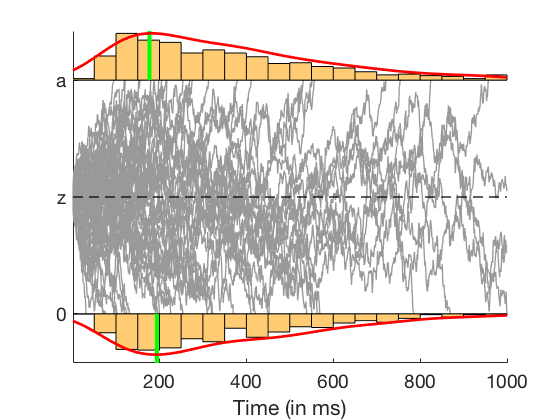

In [28]:
%addpath(~/Location/of/your/function)

pm = struct; % create empty structure
[RT,decision,evidence,pm] = driftdiff(pm); % run default simulation

% Plot outcome with custom function 'plotDrift'
figure;
plotDrift(RT,decision,evidence,pm); 

That doesn't look much like the image at the beginning of this tutorial or the plots we're used to in papers. That's because this default model assumes a single drift rate `pm.driftrate = 0`. That is equivalent to saying "Every stimulus I see is equally difficult to perceive and it contains no evidence for either option". In other words, these RT distributions are generated purely by noise. I highlight the mode of the fitted distribution with a green line, which should make comparison between distributions slightly easier.

**NOTE**: Choosing the initial parameter values seems pretty arbitrary to me. Because different combinations of parameter values can produce exactly the same shape of distributions.

**NOTE**: I won't say too much about the 'plotDrift' function, all of it is explained when typing `help plotDrift`. I just want to add that the function takes `nbins` equally spaced bins over the whole epoch. I then fit a 'kernel' distribution to the histogram, which doesn't assume a specific shape. Ratcliff & McKoon (2008) however suggest, when fitting distributions to the empirical RT data, you summarise it for the quantiles [.1 .3 .5 .7 .9]. Moreover the distribution generally fitted to RT data is the ex-Gaussian. Unfortunately, fitting it is not straightforward in Matlab, as it is not included in the standard packages. For illustration purposes and ease, I decided to do it my way.

## Changing the parameters

Finally we get to the fun bit where we adjust some parameters to observe their impact on the model outcomes. Let's first decide on a model that can be our reference for later simulations. We'll work with a model that has a single drift rate `pm.driftrate = 1`, again as if we assume all stimuli contain the same amount of information favouring one option. In this case, you can consider bound $a$ to be the 'correct' bound and bound $0$ the 'incorrect' bound.

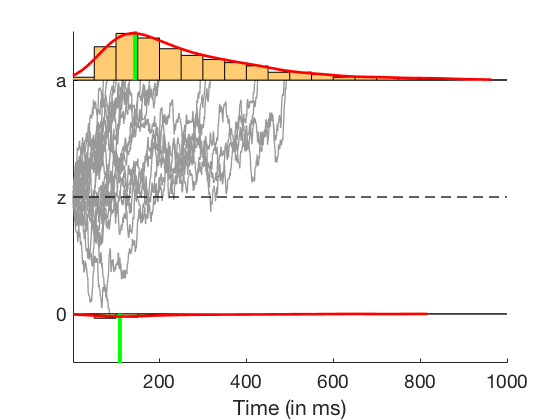

In [26]:
pm = struct; % empty structure
pm.driftrate = 1; % evidence for option A

[RT,decision,evidence,pm] = driftdiff(pm);
figure; plotDrift(RT,decision,evidence,pm,20);

### Drift rate

When we double the drift rate, we are effectively increasing the quality of the evidence. As you would expect from having better information, this will lead to decreased RT's and fewer errors.

**NOTE**: I won't show it in this tutorial, but you could input a whole vector (ntrials x 1) with varying levels of stimulus evidence rather than a single drift rate. All trials where DV > 0, the stimulus contained evidence for option A and all trials where DV < 0 has evidence for option B. 

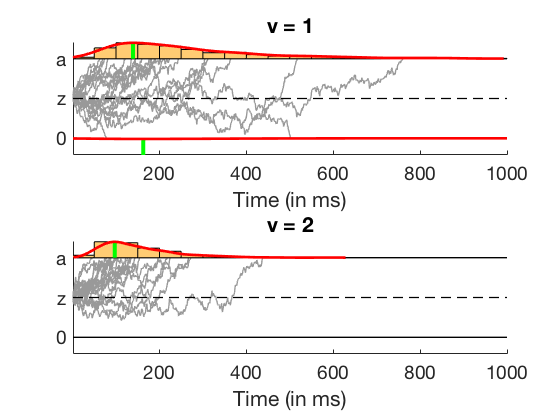

In [1]:
pm = struct; % empty structure
pm.driftrate = 1; % evidence for option A

figure; 

% Default model
[RT,decision,evidence,pm] = driftdiff(pm);
subplot(2,1,1); plotDrift(RT,decision,evidence,pm,20); 
title(['v = ' num2str(pm.driftrate(1))]);

% Higher drift model
pm.driftrate = 2; % more evidence for option A
[RT,decision,evidence,pm] = driftdiff(pm);
subplot(2,1,2); plotDrift(RT,decision,evidence,pm,20); 
title(['v = ' num2str(pm.driftrate(1))]);

Another property of the drift rate is the standard deviation of the noise $\eta$. Sometimes integration might be noisier, for example due to fatigue or inattention. Maybe less intuitive, when decreasing the noise, RT's will be slower compared to higher noise. This is due to the fact that noise is less likely to drive the information over the bound very quickly by chance. Hence, you will see less errors, a shorter tail, but also higher RT's.

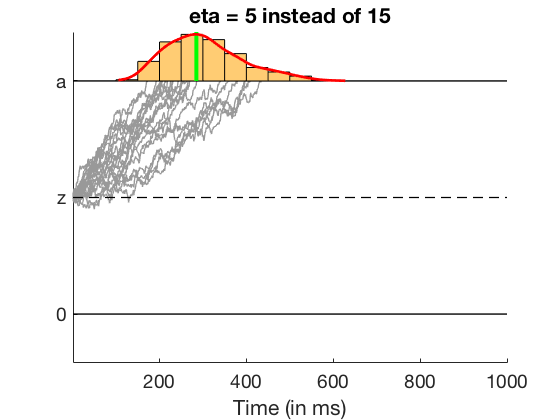

In [37]:
pm = struct; % empty structure
pm.driftrate = 1; % evidence for option A

figure; 

% Lower noise model
pm.noise = 5; % decrease noise level
[RT,decision,evidence,pm] = driftdiff(pm);
plotDrift(RT,decision,evidence,pm,20); 
title(['eta = ' num2str(pm.noise(1)) ' instead of ' num2str(15)]);

### Bounds

Changing the bounds directly relates to the trade-off between RT and accuracy (SAT). For example, giving instructions that focus on accuracy will elicit different behaviour than when you focus on speed. In the DDM this is easily modelled by changing the distance between the bounds. Bringing the bounds closer together will result in a particle reaching a bound sooner, but can also drive it towards the wrong bound. 

Both drift rate and changing bounds influence RT and error rate, but in a different way. Ratcliff & McKoon (2008) mention that both will have an influence on the shape of your RT distribution, but will do so in a 2:1 ratio (right tail vs leading edge) for the drift rate, and in a 4:1 ratio for the changing bounds.

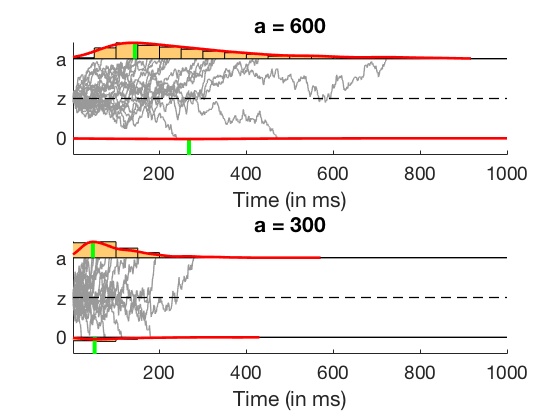

In [39]:
pm = struct; % empty structure
pm.driftrate = 1; % evidence for option A

figure; 

% Default model
[RT,decision,evidence,pm] = driftdiff(pm);
subplot(2,1,1); 
plotDrift(RT,decision,evidence,pm,20); 
title(['a = ' num2str(pm.upperbound(1))]);

% Decreased bounds model
pm.upperbound = 300; % decrease bound a
pm.bias = pm.upperbound/2; % keep starting point in the middle!

[RT,decision,evidence,pm] = driftdiff(pm);
subplot(2,1,2); 
plotDrift(RT,decision,evidence,pm,20); 
title(['a = ' num2str(pm.upperbound(1))]);

### Bias

Let's consider for this section that our two bounds no longer represent correct and incorrect responses - it is nonsensical to be biased towards a correct response. Imagine the situation where for example you receive a higher reward when option A is the correct answer, but you need to answer within a certain deadline. In that case you might want to be sure you always get option A, even when that means missing option B more often. We expect to see faster and more frequent responses for A and slower and fewer responses for B. In the DDM this behaviour is explained by shifting the starting point $z$ towards bound $a$. 

For our simulation, let's have the stimulus contain absolutely no information to see how our model will make more choices for option A because of the bias. To make use of all properties of the bias, we will also assume the bias varies from trial to trial by introducing a uniform range around the bias.

**NOTE**: With just a single drift rate, changing the bias or the zero point will have exactly the same result for this function. However, differences between these two kinds of biases arise when you consider that the stimulus quality (i.e. drift rate) varies over trials. Shifting the prior will be an *additive* bias, while the zero point will be a *multiplicative* bias.

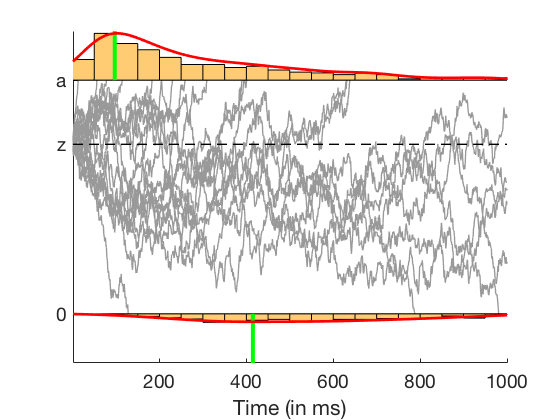

In [3]:
pm = struct; % empty structure

figure; 

% Biased model
pm.bias = .7; % bias for option A
pm.biasrange = .05; % bias ranges from .675 - .725
[RT,decision,evidence,pm] = driftdiff(pm);
plotDrift(RT,decision,evidence,pm,20); 

### Non-decision time

Non-decision time is simply implemented as a waiting period before the onset of the integration process. This is a bit counterintuitive when you consider it to contain time consumed by motor output processes, i.e. things happening after the integration process. The details don't really matter, all it needs to do is account for an overall shift in the distributions. Again, we'll let the non-decision time vary uniformly as in most DDM.

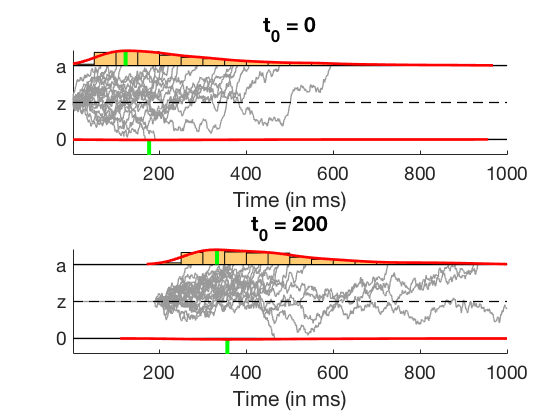

In [53]:
pm = struct; % empty structure
pm.driftrate = 1; % evidence for option A

figure; 

% Default model
[RT,decision,evidence,pm] = driftdiff(pm);
subplot(2,1,1); 
plotDrift(RT,decision,evidence,pm,20); 
title(['t_0 = ' num2str(pm.nondectime(1))]);

% Delayed model
pm.nondectime = 200; % wait 200 ms before integration
pm.ndcrange = 25; % waiting time varies between 175 and 225 ms

[RT,decision,evidence,pm] = driftdiff(pm);
subplot(2,1,2); 
plotDrift(RT,decision,evidence,pm,20); 
title(['t_0 = ' num2str(round(mean(pm.nondectime)))]);

The other components go beyond a simple drift diffusion model and I won't discuss them here. Note that you could manipulate `pm.leak` or `pm.lambda` (Ornstein-Uhlenbeck) with this function. I also haven't discussed any interaction between parameters. For example, non-decision time will have a greater effect on the RT distribution when drift rates are higher.

## Extensions of the standard model

The DDM has been very succesful in explaining choice behaviour and has been extended in various ways. To make my life a little easier, here is an overview by Ratcliff et al. (2016) of the different sorts of DDM models developed over the years.

<img src='Family_tree_DDM.png' style="width: 80%; height: 80%">

Furthermore, there are models that expand the standard model to explain things such as confidence, urgency, value-based decision-making, etc. Here is a non-extensive list of such models:

- Attentional DDM (aDDM; Krajbich, 2010): a model that incorporates eye-movements to explain (higher-level) choices
- Leaky competing accumulator (LCA; Usher & McClelland, 2002): I mention it here again, because it can be extended to multi-alternative choices (> 2) and explain higher-level behavioural effects, such as preference reversal (Tsetsos, 2012)
- Wang (2008): biophysically plausible model for multi-alternative choices
- Vickers (1979): a race model that explains confidence ratings
- van den Berg et al. (2016): shows how changes of mind can be explained with a drift model

For a more extensive overview of sequential sampling models and their extensions, I refer to a review by Forstmann et al. (2016).

## Fitting the DDM

Unfortunately, fitting the model to experimental data was outside the scope of this tutorial and I will leave that for another tutorial. There are quite a few packages out there that fit DDM and should work well, if used properly. Check out Ratcliff & Childers (2015), ['Individual Differences and Fitting Methods for the Two-Choice Diffusion Model of Decision Making'](http://europepmc.org/articles/pmc4517692) for a comparison between the available packages.

## Further reading

- Forstmann et al. (2016), ['Sequential Sampling Models in Cognitive Neuroscience: Advantages, Applications, and Extensions'](http://www.annualreviews.org/doi/abs/10.1146/annurev-psych-122414-033645)
- Ratcliff & McKoon (2008), ['The Diffusion Decision Model: Theory and Data for Two-Choice Decision Tasks'](http://www.mitpressjournals.org/doi/pdfplus/10.1162/neco.2008.12-06-420)
- Ratcliff et al. (2016), ['Diffusion Decision Model: Current Issues and History'](https://pdfs.semanticscholar.org/c56d/b2df697dbdc4523c7ba4373073127d67e75d.pdf)
- Shadlen & Shohamy (2016), ['Decision Making and Sequential Sampling from Memory'](http://www.sciencedirect.com/science/article/pii/S0896627316301234)
- Voss et al. (2013), ['Diffusion Models in Experimental Psychology: A Practical Introduction'](http://www.psychologie.uni-heidelberg.de/ae/meth/team/voss/paper/voss_nagler_lerche_2013.pdf)
